<a href="https://colab.research.google.com/github/VladimirVladetic/Gender-AgePredictor/blob/main/age_and_gender_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
import zipfile
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l1_l2, l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
source_path = '/content/kaggle.json'
destination_path = '/root/.kaggle/kaggle.json'
kaggle_dir = '/root/.kaggle/'
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)
os.rename(source_path, destination_path)

In [4]:
!kaggle datasets download -d jangedoo/utkface-new

100% 330M/331M [00:08<00:00, 46.1MB/s]
100% 331M/331M [00:08<00:00, 40.2MB/s]


In [5]:
with zipfile.ZipFile('/content/utkface-new.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [6]:
## Function returns paths to images and their associated age and gender labels
def get_image_paths_age_gender_labels(image_directory):
    image_paths = []
    age_labels = []
    gender_labels = []
    for filename in tqdm(os.listdir(image_directory )):
        image_path = os.path.join(image_directory,filename)
        temporary_data = filename.split("_")
        age = int(temporary_data[0])
        gender = int(temporary_data[1])
        image_paths.append(image_path)
        age_labels.append(age)
        gender_labels.append(gender)
    return image_paths, age_labels, gender_labels

In [7]:
def map_age_to_category(age):
  age_ranges = [(0, 2), (3, 5), (6, 20), (21, 40), (41, 60), (61, 80), (81, 120)]
  for category, (min_age, max_age) in enumerate(age_ranges, start=0):
          if min_age <= age <= max_age:
              return category
  return 0

In [8]:
### EDA ###

## Function takes the first 16 images of the dataset and displays them
def show_examples(df, gender_dictionary, start_image_index):
    number_of_images = 16
    plt.figure(figsize=(number_of_images,number_of_images))
    files = df.iloc[start_image_index:start_image_index + number_of_images]
    i = 0
    for index, image, age, gender in files.itertuples():
        i+=1
        plt.subplot(4,4, i)
        var_image = load_img(image)
        var_image = np.array(var_image)
        plt.imshow(var_image)
        plt.title(f"Age: {age} Gender: {gender_dictionary[gender]}")
        plt.axis("off")
    plt.show()

# Plotting bar graph for gender
def plot_gender(df):
    plt.figure(figsize=(10, 5))
    df['gender'].value_counts().plot(kind='bar', color=['blue', 'pink'])
    plt.title('Gender Distribution')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.show()

# Plotting age histogram
def plot_age(df):
    plt.figure(figsize=(15, 5))
    df['age'].plot(kind='hist', bins=20, edgecolor='black')
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.show()

In [9]:
# Extracting features from the images
def extract_features(images, height, width):
    features = []
    for image in tqdm(images):
        var_img = load_img(image, grayscale = True)
        var_img = var_img.resize((height,width), Image.ANTIALIAS)
        var_img = np.array(var_img)
        ## Normalization of images
        var_img = var_img / 255.0
        features.append(var_img)
    features = np.array(features)
    features = features.reshape(len(features), height, width, 1)
    ## from float64 to float32
    features = np.array(features, dtype=np.float32)
    return features

In [ ]:
""" OLD MODEL BEST MODEL
# Creating a custom model
def create_model(input_shape):
    inputs = Input(input_shape)
    conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
    maxp_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
    conv_2 = Conv2D(64, kernel_size=(3,3), activation='relu')(maxp_1)
    maxp_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
    conv_3 = Conv2D(128, kernel_size=(3,3), activation='relu')(maxp_2)
    maxp_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
    conv_4 = Conv2D(256, kernel_size=(3,3), activation='relu')(maxp_3)
    maxp_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

    flatten = Flatten()(maxp_4)

    dense_1 = Dense(256, activation='relu')(flatten)
    dense_2 = Dense(256, activation='relu')(flatten)

    dropout_1 = Dropout(0.3)(dense_1)
    dropout_2 = Dropout(0.3)(dense_2)

    output_1 = Dense(1, activation='sigmoid', name="gender_out")(dropout_1)
    output_2 = Dense(7, activation='softmax', name="age_out")(dropout_2)

    model = Model(inputs=[inputs], outputs=[output_1, output_2])
    return model
"""

In [ ]:
""" Gender 90%, Age 75%
def create_model(input_shape):
    inputs = Input(input_shape)

    conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
    batch_1 = BatchNormalization()(conv_1)
    maxp_1 = MaxPooling2D(pool_size=(2,2))(batch_1)

    conv_2 = Conv2D(64, kernel_size=(3,3), activation='relu')(maxp_1)
    batch_2 = BatchNormalization()(conv_2)
    maxp_2 = MaxPooling2D(pool_size=(2,2))(batch_2)

    conv_3 = Conv2D(128, kernel_size=(3,3), activation='relu')(maxp_2)
    batch_3 = BatchNormalization()(conv_3)
    maxp_3 = MaxPooling2D(pool_size=(2,2))(batch_3)

    conv_4 = Conv2D(256, kernel_size=(3,3), activation='relu')(maxp_3)
    batch_4 = BatchNormalization()(conv_4)
    maxp_4 = MaxPooling2D(pool_size=(2,2))(batch_4)

    conv_5 = Conv2D(512, kernel_size=(3,3), activation='relu')(maxp_4)
    batch_5 = BatchNormalization()(conv_5)

    flatten = Flatten()(batch_5)

    dense_1_1 = Dense(256, activation='relu')(flatten)
    dense_2_1 = Dense(256, activation='relu')(flatten)

    dropout_1 = Dropout(0.3)(dense_1_1)
    dropout_2 = Dropout(0.3)(dense_2_1)

    dense_1_2 = Dense(256, activation='relu')(dropout_1)
    dense_2_2 = Dense(256, activation='relu')(dropout_2)

    output_1 = Dense(1, activation='sigmoid', name="gender_out")(dense_1_2)
    output_2 = Dense(7, activation='softmax', name="age_out")(dense_1_2)

    model = Model(inputs=[inputs], outputs=[output_1, output_2])
    return model
"""

In [10]:
def create_model(input_shape):
    inputs = Input(input_shape)

    conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
    batch_1 = BatchNormalization()(conv_1)
    maxp_1 = MaxPooling2D(pool_size=(2,2))(batch_1)

    conv_2 = Conv2D(64, kernel_size=(3,3), activation='relu')(maxp_1)
    batch_2 = BatchNormalization()(conv_2)
    maxp_2 = MaxPooling2D(pool_size=(2,2))(batch_2)

    conv_3 = Conv2D(128, kernel_size=(3,3), activation='relu')(maxp_2)
    batch_3 = BatchNormalization()(conv_3)
    maxp_3 = MaxPooling2D(pool_size=(2,2))(batch_3)

    conv_4 = Conv2D(256, kernel_size=(3,3), activation='relu')(maxp_3)
    batch_4 = BatchNormalization()(conv_4)
    maxp_4 = MaxPooling2D(pool_size=(2,2))(batch_4)

    conv_5 = Conv2D(512, kernel_size=(3,3), activation='relu')(maxp_4)
    batch_5 = BatchNormalization()(conv_5)

    flatten = Flatten()(batch_5)

    dense_1_1 = Dense(256, activation='relu', kernel_regularizer=l1(0.01))(flatten)
    dense_2_1 = Dense(256, activation='relu', kernel_regularizer=l1(0.01))(flatten)

    dropout_1 = Dropout(0.3)(dense_1_1)
    dropout_2 = Dropout(0.3)(dense_2_1)

    dense_1_2 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(dropout_1)
    dense_2_2 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(dropout_2)

    dropout_3 = Dropout(0.3)(dense_1_2)
    dropout_4 = Dropout(0.3)(dense_2_2)

    dense_1_3 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(dropout_3)
    dense_2_3 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(dropout_4)

    output_1 = Dense(1, activation='sigmoid', name="gender_out")(dense_1_3)
    output_2 = Dense(7, activation='softmax', name="age_out")(dense_2_3)

    model = Model(inputs=[inputs], outputs=[output_1, output_2])
    return model

In [11]:
def display_gender_acc_graph(history):
    acc = history.history["gender_out_accuracy"]
    val_acc = history.history["val_gender_out_accuracy"]
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b', label="Training Accuracy")
    plt.plot(epochs, val_acc, 'r', label="Validation Accuracy")
    plt.title("Gender Accuracy Graph")
    plt.legend()
    plt.figure()

def display_gender_loss_graph(history):
    loss = history.history["gender_out_loss"]
    val_loss = history.history["val_gender_out_loss"]
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'b', label="Training Loss")
    plt.plot(epochs, val_loss, 'r', label="Validation Loss")
    plt.title("Gender Loss Graph")
    plt.legend()
    plt.show()

def display_age_acc_graph(history):
    acc = history.history["age_out_accuracy"]
    val_acc = history.history["val_age_out_accuracy"]
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b', label="Training Accuracy")
    plt.plot(epochs, val_acc, 'r', label="Validation Accuracy")
    plt.title("Age Accuracy Graph")
    plt.legend()
    plt.figure()

def display_age_loss_graph(history):
    loss = history.history["age_out_loss"]
    val_loss = history.history["val_age_out_loss"]
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'b', label="Training Loss")
    plt.plot(epochs, val_loss, 'r', label="Validation Loss")
    plt.title("Age Loss Graph")
    plt.legend()
    plt.show()

In [12]:
## Set image Directory
image_directory = "/content/UTKFace/"

image_paths, age_labels, gender_labels = get_image_paths_age_gender_labels(image_directory)

age_categories = [map_age_to_category(age) for age in age_labels]
"""
one_hot_encoded_age = to_categorical(age_categories, num_classes=8)

flattened_age_labels = one_hot_encoded_age.tolist()
"""

## Set Dictionary
gender_dictionary = {0:"Male",1:"Female"}

## Structure of df: INDEX, PICTURE FILEPATH, AGE LABEL, GENDER LABEL
df = pd.DataFrame()
df["image"], df["age"], df["gender"] = image_paths, age_categories, gender_labels
##print(df)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
### EDA ###

##show_examples(df, gender_dictionary, 500)

##plot_age(df)

##plot_gender(df)

In [13]:
## Worth trying changing the height and width to a smaller size and upping float32 to 64
## back in the extract features function
image_height = 128
image_width = 128

"""
image_height = 128
image_width = 128
"""

'\nimage_height = 128\nimage_width = 128\n'

In [14]:
X = extract_features(df["image"],image_height,image_width)
## Normalization not used due to it being done in the function
## X = X/255.0

y_gender = np.array(df["gender"])
y_age = np.array(df["age"])

y_age = np.array(list(df["age"].apply(lambda x: to_categorical(x, num_classes=7))))

y_gender_tensor = tf.convert_to_tensor(y_gender, dtype=tf.float32)
y_age_tensor = tf.convert_to_tensor(y_age, dtype=tf.float32)

input_shape = (image_height,image_width,1)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
print(y_age)

In [16]:
opt = Adam(learning_rate=0.001)

model = create_model(input_shape)

model.compile(loss=["binary_crossentropy", "categorical_crossentropy"], optimizer = opt, metrics=["accuracy"])

lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5)

history = model.fit(x=X, y=[y_gender_tensor, y_age_tensor], batch_size=32, epochs=50, validation_split=0.3, callbacks=[lr_scheduler])

Epoch 1/50
519/519 [==============================] - 27s 38ms/step - loss: 22.8787 - gender_out_loss: 0.4285 - age_out_loss: 1.0985 - gender_out_accuracy: 0.7998 - age_out_accuracy: 0.5854 - val_loss: 7.5145 - val_gender_out_loss: 0.5710 - val_age_out_loss: 1.2875 - val_gender_out_accuracy: 0.7176 - val_age_out_accuracy: 0.5093 - lr: 0.0010
Epoch 2/50
519/519 [==============================] - 18s 34ms/step - loss: 6.6048 - gender_out_loss: 0.3040 - age_out_loss: 0.8869 - gender_out_accuracy: 0.8611 - age_out_accuracy: 0.6545 - val_loss: 6.6732 - val_gender_out_loss: 0.2977 - val_age_out_loss: 1.0016 - val_gender_out_accuracy: 0.8589 - val_age_out_accuracy: 0.6199 - lr: 0.0010
Epoch 3/50
519/519 [==============================] - 18s 35ms/step - loss: 6.2337 - gender_out_loss: 0.2611 - age_out_loss: 0.7858 - gender_out_accuracy: 0.8850 - age_out_accuracy: 0.6888 - val_loss: 6.6104 - val_gender_out_loss: 0.3445 - val_age_out_loss: 1.2043 - val_gender_out_accuracy: 0.8517 - val_age_out_

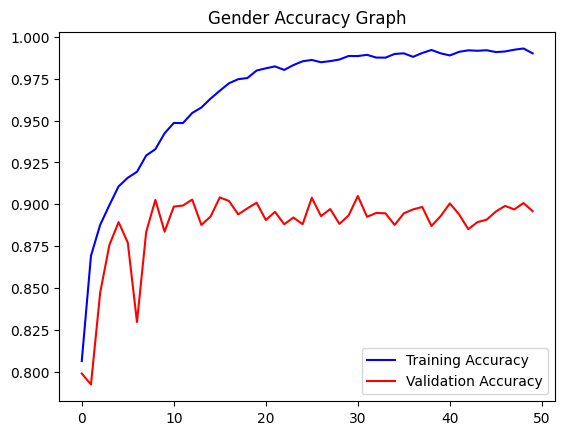

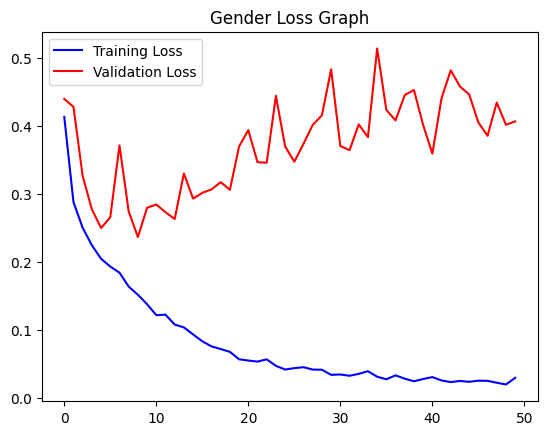

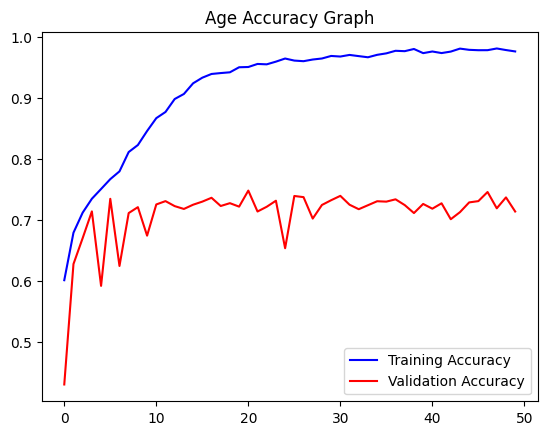

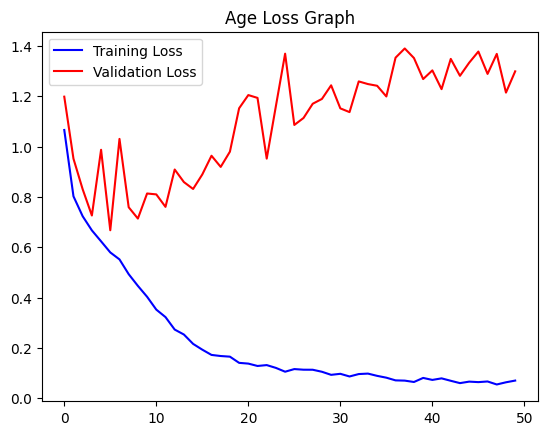

In [ ]:
display_gender_acc_graph(history)

display_gender_loss_graph(history)

display_age_acc_graph(history)

display_age_loss_graph(history)